In [14]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [15]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.cluster as sc
from sklearn.metrics import (
    davies_bouldin_score,
    calinski_harabasz_score,
    silhouette_score
)

from audiovocana.conf import (FFTFREQS, MELFREQS)
from audiovocana.dataset import get_dataset
from audiovocana.color import (
    COLORS,
    dec
)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [16]:
PLOT = True

MIN_NB_CLUTERS = 2
MAX_NB_CLUTERS = 8

FILTERS = [
    {'vocalization': 1, 'year': 17},
    {'vocalization': 1, 'year': 19},
]
FEATS = ['mean_stft']  #  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']

AFFINITIES = ["euclidean"]  # ["euclidean", "cosine",  "sqeuclidean", "cityblock"]
LINKAGES = ["ward"]  # ["complete", "average", "single"] # ["ward"]

CSV_PATH = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
CACHE_FOLDER = '/home/utilisateur/Desktop/palomars/cache/full_dataset'
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/usv-experiments/full-dataset/results"


def results_folder(filters):
    return os.path.join(
        RESULTS_FOLDER,
        '_'.join([f"{k}:{v}" for k, v in filters.items()]),
        'clustering'
    )

# Get dataset

In [17]:
dataset = get_dataset(
    csv_path=CSV_PATH,
    cache_folder=CACHE_FOLDER
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


# Apply filters

In [18]:
def filter_dataset(dataset, filters):
    dataset = dataset.filter(lambda sample: sample['year'] == filters['year'])
    dataset = dataset.filter(lambda sample: sample['vocalization'] == filters['vocalization'])
    return dataset

# Retrieve metadata and features

In [19]:
KEYS = ['vocalization', 'mother', 'year', 'nest', 'postnatalday',  'event', 'recording']

def get_feats_and_metadata(dataset):
    metadata = pd.DataFrame.from_records([
        {k: dec(sample[k].numpy()) for k in KEYS}
        for sample in dataset
    ])


    feats = {feat: [] for feat in FEATS}
    for sample in dataset:
        for feat in FEATS:
            feats[feat].append(sample[feat].numpy())

    feats = {k: np.array(v).T for k, v in feats.items()}
    
    return feats, metadata

# Set colors

In [20]:
keys_colors = ['vocalization', 'mother',  'postnatalday', 'nest',  'recording']

def get_colors(metadata, filters):
    COLORS['recording'] =  dict(zip(
            set(metadata['recording']),
            sns.light_palette(COLORS['year'][filters['year']], len(set(metadata['recording'])))))

    colors = pd.concat([metadata[k].map(COLORS[k]) for k in keys_colors], axis=1)
    colors.columns = keys_colors
    return colors

In [21]:
def get_ylabels(name, num):
    if name == 'stft':
        return [str(i)+' Hz' for i in np.linspace(FFTFREQS[0], FFTFREQS[-1], num=num, dtype=np.int)]
    elif name == '_mel':
        return [str(i)+' Hz' for i in np.linspace(MELFREQS[0], MELFREQS[-1], num=num, dtype=np.int)]
    elif name == 'mfcc':
        return np.linspace(0, num, num=num, dtype=np.int)


# Hiercharchical clustering

In [22]:
def hcluster(X, min_clusters, max_clusters, method, metric, colors, feat, nb_cluster_labels):
    
    cluster_assigns = {}

    g = sns.clustermap(
        pd.DataFrame(X),
        method=method,
        metric=metric,
        standard_scale=None, # Max-0 scaling. Either 0 (rows) or 1 (columns) or None
        z_score=0, # Whitening. Either 0 (by rows) or 1 (by columns) or None
        row_cluster=False,
        col_colors=colors,
        center=None, # check what this is, looks different with 0
        figsize=(16, 8),
        cbar_pos=None,
        xticklabels=1,
        yticklabels='auto'
    )

    plt.close('all')

    # linkage matrix
    Z = g.dendrogram_col.linkage
    for n in range(min_clusters, max_clusters+1):
        n_assigs = sc.hierarchy.fcluster(Z, t=n, criterion='maxclust')
        cluster_assigns[n] = n_assigs
        clusters = range(1, n+1)
        dicc_clusters =  dict(zip(
            clusters,
            sns.color_palette("cubehelix", n)))
        colors_clusters = pd.DataFrame(n_assigs)[0].map(dicc_clusters)

        tmp_colors = [f'{n}-clusters-labels'] + colors.columns.tolist()
        colors = pd.concat([colors_clusters, colors], axis=1)
        colors.columns = tmp_colors

    g = sns.clustermap(
        pd.DataFrame(X),
        method=method,
        metric=metric,
        standard_scale=None, # Max-0 scaling. Either 0 (rows) or 1 (columns) or None
        z_score=0, # Whitening. Either 0 (by rows) or 1 (by columns) or None
        row_cluster=False,
        col_colors=colors,
        center=None, # check what this is, looks different with 0
        figsize=(16, 8),
        cbar_pos=None,
        xticklabels=7,
        yticklabels='auto')
           
    reord_ind = g.dendrogram_col.reordered_ind
    g.ax_heatmap.axes.set_xticklabels(
        cluster_assigns[nb_cluster_labels][reord_ind][np.arange(0, len(reord_ind), 7)]
    )
    for tick in g.ax_heatmap.axes.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
        tick.label.set_rotation('horizontal') 
    
    g.ax_heatmap.axes.set_yticklabels(
        get_ylabels(
            name=feat[-4:],
            num=len(g.ax_heatmap.axes.yaxis.get_major_ticks())
        )
    )

    for tick in g.ax_heatmap.axes.yaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
        tick.label.set_rotation('horizontal')

    return g, cluster_assigns

{'vocalization': 1, 'year': 19}
mean_stft-ward-euclidean


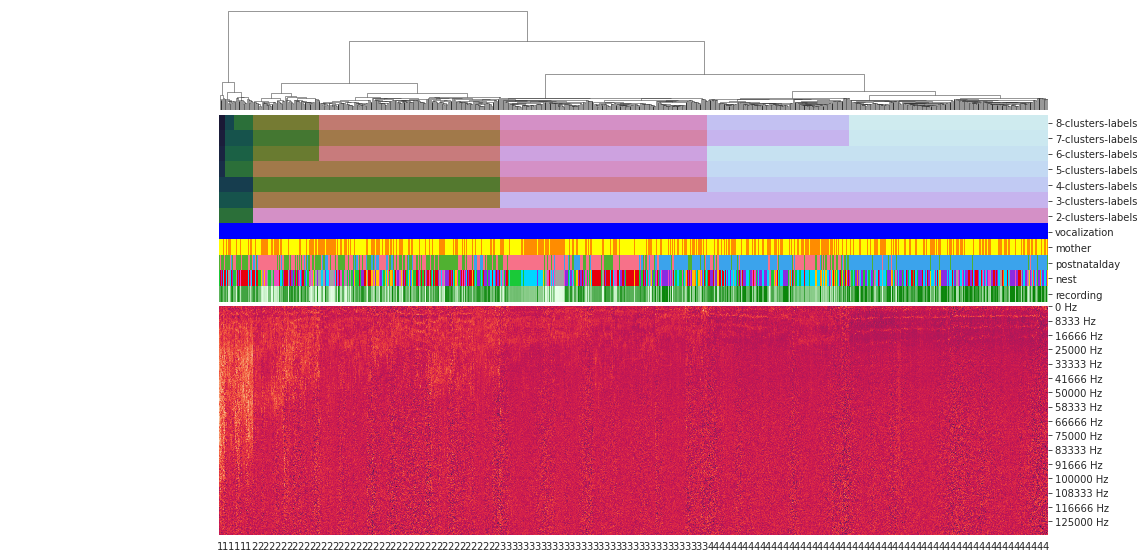

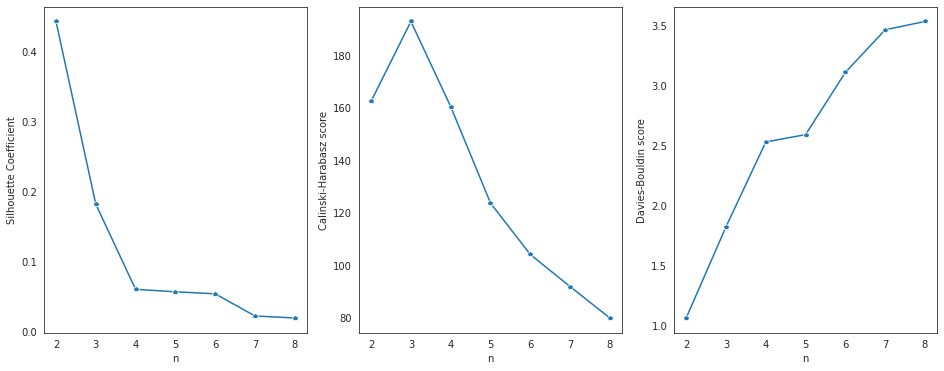

In [23]:
for filters in FILTERS[1:]:

    feats, metadata = get_feats_and_metadata(filter_dataset(dataset, filters))
    colors = get_colors(metadata, filters)

    for feat in FEATS:
        for linkage in LINKAGES:
            for metric in AFFINITIES:

                title = f"{feat}-{linkage}-{metric}"
                print(filters)
                print(title)

                X = feats[feat]
                g, cluster_assigns = hcluster(
                    X, MIN_NB_CLUTERS, MAX_NB_CLUTERS, linkage, metric, colors, feat, nb_cluster_labels=4)

                folder = results_folder(filters)
                g.savefig(os.path.join(folder, "clustermap", f"{title}.png"))
                metadata.assign(**{f"clust{k}": v for k,v in cluster_assigns.items()}).to_csv(
                    os.path.join(folder, "cluster_assigns", f"{title}.csv"), index=False)

                results = []
                for n in range(MIN_NB_CLUTERS, MAX_NB_CLUTERS+1):
                    results.append({
                        "n": n,
                        "Calinski-Harabasz score": calinski_harabasz_score(X.T, cluster_assigns[n]),
                        "Davies-Bouldin score": davies_bouldin_score(X.T, cluster_assigns[n]),
                        "Silhouette Coefficient": silhouette_score(X.T, cluster_assigns[n]),
                })
                results = pd.DataFrame.from_records(results)

                f, axes = plt.subplots(1, 3, figsize=(16, 6))
                sns.lineplot(x='n', y='Silhouette Coefficient', data=results, marker='p', ax=axes[0])
                sns.lineplot(x='n', y='Calinski-Harabasz score', data=results, marker='p', ax=axes[1])
                sns.lineplot(x='n', y='Davies-Bouldin score', data=results, marker='p', ax=axes[2])

                #results.to_csv(
                #    os.path.join(folder, "cluster_metrics", f"{title}.csv"), index=False)
                
                plt.show()